In [1]:
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 300)

# Read data
movie = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv', delimiter='\t', header=None)
movie.columns = ["movie_id", 1, "movie_name", 3, 4, 5 ,6, 7, "genre"]
plot = pd.read_csv('Data/MovieSummaries/plot_summaries.txt', delimiter='\t', header=None)
plot.columns = ["movie_id", "plot"]

data = movie[["movie_id", "movie_name", "genre"]].merge(plot, on="movie_id")

# Extract genres
genre = []
for i in data["genre"]:
    genre.append(list(json.loads(i).values()))
data["genre_new"] = genre
data_new = data[~(data["genre_new"].str.len() == 0)]

# Preprocessing functions
def clean_text(text):
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(text.split())
    text = text.lower()
    return text

def remove_stopwords(text):
    no_stop = []
    for i in text.split():
        if i not in stopwords:
            no_stop.append(i)
    return " ".join(no_stop)

def freq_plot(text):
    
    words = " ".join([x for x in text])
    words = words.split()
    fdist = nltk.FreqDist(words)
    return fdist



In [2]:

genre = []

for i in data["genre"]:
    #print(list(json.loads(i).values()))
    genre.append(list(json.loads(i).values()))

data["genre_new"] = genre

data_new = data[~(data["genre_new"].str.len() == 0)]

dumm = []

for i in genre:
    for j in i:
        #print(j)
        dumm.append(j)
all_genre = list(set(dumm))


genre_new = nltk.FreqDist(dumm)
genre_df = pd.DataFrame.from_dict(genre_new, orient="index")
genre_df.columns = ["Count"]
genre_df = genre_df.reset_index()
genre_df.columns = ["Genre", "Count"]


#plt.figure(figsize=(12,12))
#sns.barplot(data=genre_df.sort_values("Count", ascending=False).loc[:20, :], x="Count", y="Genre")

In [3]:
#------------------#
#Delte film with only one genre and this genre is less than 10 films

#film per genre
film_per_genre = pd.DataFrame(columns=["Genre", "Count"])
film_per_genre["Genre"] = all_genre

for i in range(len(film_per_genre)):
    film_per_genre["Count"][i] = len(data_new[data_new["genre_new"].apply(lambda x : film_per_genre["Genre"][i] in x)])

film_per_genre = film_per_genre.sort_values("Count", ascending=False)
film_per_genre = film_per_genre.reset_index(drop=True)
print(film_per_genre)

#delete all film from data_new with only one genre and this genre is less than 10 films
data_new = data_new[data_new["genre_new"].apply(lambda x : (len(x) > 1) & (film_per_genre[film_per_genre["Genre"] == x[0]]["Count"].values[0] > 100))]

#clean text
data_new["clean_plot"] = data_new["plot"].apply(lambda x : clean_text(x))

                    Genre  Count
0                   Drama  19134
1                  Comedy  10467
2            Romance Film   6666
3                Thriller   6530
4                  Action   5868
..                    ...    ...
358            War effort      1
359            Breakdance      1
360  Political Documetary      1
361            Neorealism      1
362        Patriotic film      1

[363 rows x 2 columns]


In [4]:
# Get stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
data_new["clean_plot"] = data_new["clean_plot"].apply(lambda x : remove_stopwords(x))

# Binarize genres
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_bina = MultiLabelBinarizer()
multilabel_bina.fit(data_new["genre_new"])
y = multilabel_bina.transform(data_new["genre_new"])

# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(max_df= 0.8, max_features=10000)
xtrain, xval, ytrain, yval = train_test_split(data_new["clean_plot"], y, test_size = 0.2, random_state= 9)
xtrain_tfidf = tfidf_vect.fit_transform(xtrain)
xval_tfidf = tfidf_vect.transform(xval)

In [5]:
#make list aff all genre
genre_list = []
for i in range(len(data_new["genre_new"])):
    genre_list.append(data_new["genre_new"].iloc[i][0])

#unique genre
unique_genre = list(set(genre_list))
len(unique_genre)

120

In [38]:
# Documents Example with 5 Plots
documents = data_new["clean_plot"][0:5].reset_index(drop=True)

# Term Frequency-Inverse Document Frequency vectorizer
Tfid_vect = TfidfVectorizer()

# Transform the documents using the vectorizer
documents_vect = Tfid_vect.fit_transform(documents)

# Convert the transformed for better visability. Normally sparse matrix
df = pd.DataFrame(documents_vect.toarray(), columns=Tfid_vect.get_feature_names_out())

df

,abandoned,abandons,act,acts,adam,adams,adultery,affair,agitates,air,...,wizard,woman,womanizing,women,working,works,world,wrapped,years,young
0,0.000000,0.000000,0.000000,0.05433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.043833,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
1,0.064031,0.032016,0.000000,0.00000,0.000000,0.000000,0.032016,0.000000,0.032016,0.032016,...,0.000000,0.000000,0.00000,0.051660,0.032016,0.00000,0.000000,0.032016,0.051660,0.02583
2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.093643,0.000000,0.00000,0.000000,0.000000,0.00000,0.187285,0.000000,0.226651,0.07555
3,0.000000,0.000000,0.000000,0.00000,0.343202,0.137281,0.000000,0.137281,0.000000,0.000000,...,0.000000,0.137281,0.06864,0.000000,0.000000,0.06864,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.515306,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000


## Clean Text process

+ Remove Apostrophes:

    This line uses regular expressions (re.sub) to replace apostrophes with nothing, effectively removing them from the text.

+ Retain Only Alphabets:

    Using regular expressions, this line replaces any character that is not an alphabet (both lowercase and uppercase) with a space.

+ Remove Extra Whitespace:

+ Convert to Lowercase

# Plot Genres

# Plot Stopwords

<Axes: xlabel='Count', ylabel='Word'>

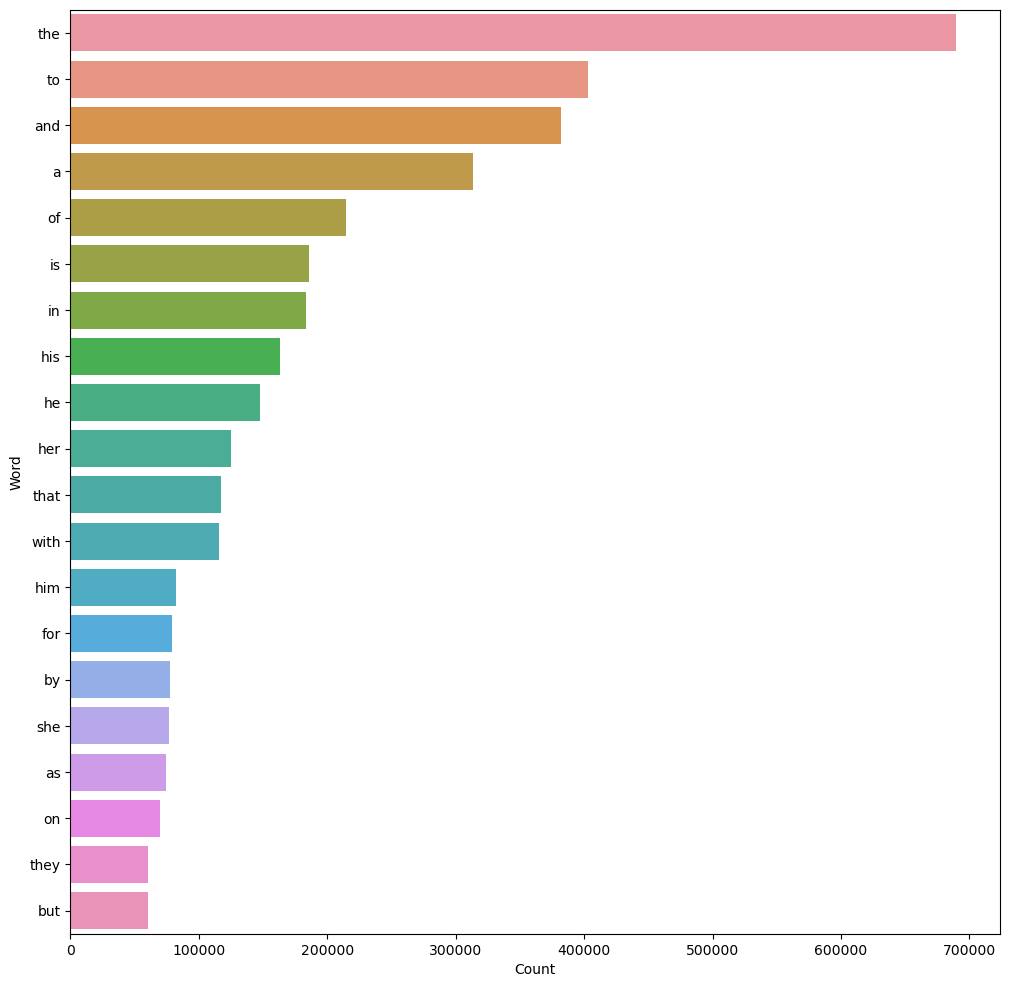

In [66]:
#data_new["clean_plot"] = data_new["plot"].apply(lambda x : clean_text(x))

fdist = freq_plot(data_new["clean_plot"])
words_df = pd.DataFrame.from_dict(fdist, orient="index")
words_df = words_df.reset_index()
words_df.columns = ["Word","Count"]


plt.figure(figsize=(12,12))
sns.barplot(data= words_df.sort_values(by="Count",ascending= False).iloc[:20, :], x = "Count", y= "Word")

# Random Forest classification

# Use Random Forest for classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

rf_classifier = RandomForestClassifier()
onevsall_rf = OneVsRestClassifier(rf_classifier)
onevsall_rf.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = onevsall_rf.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Predict function
def new_val_rf(x):  
    x = clean_text(x)
    x = remove_stopwords(x)
    x_vec = tfidf_vect.transform([x])
    x_pred = onevsall_rf.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)




In [27]:
#save model
#import pickle
#pickle.dump(onevsall_rf, open('model.pkl','wb'))


# Sample predictions
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", data_new['movie_name'][k], "\nPredicted genre: ", new_val_rf(xval[k]))
  print("Actual genre: ",data_new['genre_new'][k], "\n")

# Multi label logistic Regression

In [6]:

# Train model
logistic_mod = LogisticRegression()
onevsall = OneVsRestClassifier(logistic_mod)
onevsall.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = onevsall.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = onevsall.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)



c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 72 is present in all training examples.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 100 is present in all training examples.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 152 is present in all training examples.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00         1
           2       0.73      0.30      0.42      1080
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        82
           5       0.63      0.15      0.24       691
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        19
           8       0.70      0.16      0.26       593
           9       0.00      0.00      0.00        26
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00        20
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        26
          16       0.00      0.00      0.00         3
          17       0.00    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", data_new['movie_name'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",data_new['genre_new'][k], "\n")

Movie:  The Notorious Elinor Lee 
Predicted genre:  [('Action', 'Drama')]
Actual genre:  ['Drama', 'Early Black Cinema'] 

Movie:  Something Wicked 
Predicted genre:  [()]
Actual genre:  ['Thriller', 'Action/Adventure', 'Action', 'Psychological thriller'] 

Movie:  Stand by Me 
Predicted genre:  [('Drama',)]
Actual genre:  ['Adventure', 'Period piece', 'Coming of age', 'Film adaptation', 'Drama', 'Teen'] 

Movie:  Hellraiser: Inferno 
Predicted genre:  [('Thriller',)]
Actual genre:  ['Cult', 'Horror', 'Slasher', 'Supernatural'] 

Movie:  Monsieur Verdoux 
Predicted genre:  [('Drama',)]
Actual genre:  ['Crime Fiction', 'Crime Comedy', 'Comedy-drama', 'Black-and-white', 'Drama', 'Comedy', 'Black comedy'] 

